In [22]:
import  warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, KFold, ShuffleSplit
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
import torchvision
from torch import optim
from torch import cuda
from torch.optim.lr_scheduler import CosineAnnealingLR

import time, gc, random
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from stop_words import get_stop_words
import nltk, string
from nltk.stem.porter import PorterStemmer

import lightgbm as lgb

random.seed(2020)
np.random.seed(2020)
torch.cuda.manual_seed_all(2020)

warnings.filterwarnings('ignore')
%matplotlib inline

In [24]:
class Preprocessing:
    def __init__(self):
        self.porter = PorterStemmer()
        self.stop_words = get_stop_words('en')
        self.stop_words.append(' ')
        self.stop_words.append('')
    
    def pipeline(self, df):
        for lang in ['description']:
            #, 'translate_es', 'translate_fr', 'translate_de', 'translate_ja']:
            df[lang] = df[lang].apply(lambda x: self.change_text(x))
        return df

    def change_text(self, text):
        text = text.lower()
        text = text.replace('ml', 'machine learning')
        text = "".join([char if char not in string.punctuation else ' ' for char in text])
        text = " ".join([self.porter.stem(char) for char in text.split(' ') if char not in self.stop_words])
        return text
    
    def vectorize_tfidf(self, df):
        vec_tfidf = TfidfVectorizer()
        X = vec_tfidf.fit_transform(df.values)
        X = pd.DataFrame(X.toarray(), columns=vec_tfidf.get_feature_names())
        return X
    
    def vectorize_cnt(self, df):
        vec_cnt = CountVectorizer()
        X = vec_cnt.fit_transform(df.values)
        X = pd.DataFrame(X.toarray(), columns=vec_cnt.get_feature_names())
        return X

In [25]:
class CreateDataset(Dataset):
    def __init__(self, X, y):
        self.X=X
        self.y=y
        
    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.X)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        # argumentation
        x = self.X[index]
        x = torch.FloatTensor(x)
        
        
        if self.y!=None:
            return {
                'input': x,
                'label': torch.FloatTensor(self.y[index])
            }
        else:
            return {
                'input': x
            }

In [44]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        """if isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels[idx].item()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return dataset.imgs[idx][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[idx][1]
        elif self.callback_get_label:
            return self.callback_get_label(dataset, idx)
        else:
            raise NotImplementedError"""
        return dataset.y[idx][0]
        
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [45]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        pred_1 = pred[target<1.5][:,0]
        loss_1 = torch.mean((pred_1-1)**2)
        
        pred_2 = pred[(target>1.5)&(target<2.5)][:,1]
        loss_2 = torch.mean((pred_2-1)**2)
        
        pred_3 = pred[(target>2.5)&(target<3.5)][:,2]
        loss_3 = torch.mean((pred_3-1)**2)

        pred_4 = pred[target>3.5][:,3]
        loss_4 = torch.mean((pred_4-1)**2)
        
        loss = loss_1 + loss_2 + loss_3 + loss_4
        
        return loss

In [80]:
class CustomLoss_2(nn.Module):
    def __init__(self):
        super(CustomLoss_2, self).__init__()
        self.mse = nn.MSELoss()
        self.bcewithlogits = nn.BCEWithLogitsLoss()
        self.device = 'cuda' if cuda.is_available() else 'cpu'

    def forward(self, pred, target):
        
        onehot_target = torch.eye(4, device=self.device)[(target-1).long()]
        loss = self.bcewithlogits(pred, onehot_target)
        return loss

In [81]:
class MLPClass(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_layers):
        super().__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_layers[0]),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_layers[0], hidden_layers[1]),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_layers[1], output_size)
        )
        
            
        
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.fc(x)
        #x= self.sigmoid(x)
        x= self.softmax(x)
        return x

In [82]:
class Model_Trainer:
    def __init__(self, output_size, feature, hidden_layers, lr=6e-4, weight_decay=0.0005):
        self.device =  'cuda' if cuda.is_available() else 'cpu'
        self.model = MLPClass(len(feature), output_size, hidden_layers).to(self.device)
        #self.criterion = CustomLoss()
        self.criterion = CustomLoss_2()
        
        self.optimizer = optim.Adam(params=self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = CosineAnnealingLR(optimizer=self.optimizer, T_max=10)
        self.output_size = output_size
        self.hidden_layers = hidden_layers

    
    def load_params(self, state_dict):
        self.model.load_state_dict(state_dict)

    
    def train(self, trn_dataloader):
        self.model.train()
        avg_loss=0
        all_preds = []
        all_labels = []
        for data in trn_dataloader:
            self.optimizer.zero_grad()
            x = data['input'].to(self.device)
            label = data['label'].squeeze(1)
            if len(np.unique(label))!=4:
                continue
            label = label.to(self.device)
            x = self.model(x)   
            loss = self.criterion(x, label)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            avg_loss += loss.item()/len(trn_dataloader)
            all_preds+=x.detach().cpu().tolist()
            all_labels+=label.cpu().tolist()
            
        return avg_loss, np.array(all_preds), np.array(all_labels)

    def eval(self, val_dataloader):
        self.model.eval()
        avg_loss=0
        for data in val_dataloader:
            x = data['input'].to(self.device)
            label = data['label'].to(self.device).squeeze(1)
            x = self.model(x)
            loss = self.criterion(x, label)
            avg_loss += loss.item()/len(val_dataloader)
        return avg_loss, x.detach().cpu().numpy()
    
    def predict(self, data_loader):
        self.model.eval()
        preds = []
        for data in data_loader:
            x = data['input'].to(self.device)
            preds+=self.model(x).detach().cpu().tolist()
        return np.array(preds)

In [83]:
class Train_Predict:
    
    def __init__(self, train_df, test_df, feature, hidden_layers, lr=6e-4, weight_decay=0.0005, loop_num=1):
        self.train_df = train_df
        self.test_df = test_df
        self.feature = feature
        self.hidden_layers = hidden_layers
        self.lr=lr
        self.weight_decay = weight_decay
        self.loop_num=loop_num
        self.torch_random_state = 2020
        torch.cuda.manual_seed_all(self.torch_random_state)
    
    def init_model(self):
        self.model_trainer = Model_Trainer(output_size=4, feature=self.feature, hidden_layers=self.hidden_layers,
                                           lr=self.lr, weight_decay=self.weight_decay)
        
    def make_off_df(self, epoch_num, k):
        
        test_X, test_y = self.test_df[self.feature].values.tolist(), None
        test_data_set = CreateDataset(test_X, test_y)
        test_dataloader = DataLoader(test_data_set, shuffle=False, batch_size=len(test_data_set))
        
        
        trn_cv_loss = []
        val_cv_loss = []
        trn_score = []
        val_score = []
        
        off_df=[]

        for trn, val in tqdm( k.split(self.train_df, self.train_df.jobflag), total=k.n_splits ):
            trn_df = self.train_df.iloc[trn,:]
            val_df = self.train_df.iloc[val,:]

            trn_X, trn_y = trn_df[self.feature].values.tolist(),trn_df[['jobflag']].values.tolist() 
            val_X, val_y = val_df[self.feature].values.tolist(),val_df[['jobflag']].values.tolist() 

            trn_data_set = CreateDataset(trn_X, trn_y)
            trn_dataloader = DataLoader(trn_data_set, shuffle=False, batch_size=512, sampler=ImbalancedDatasetSampler(trn_data_set))
            val_data_set = CreateDataset(val_X, val_y)
            val_dataloader = DataLoader(val_data_set, shuffle=False, batch_size=len(val_data_set))

            all_trn_loss=[]
            all_val_loss=[]
            all_trn_score=[]
            all_val_score=[]
            
            test_df = self.test_df.copy()
            for e in range(epoch_num):
                for mm in range(4):
                    val_df[f'p_{mm+1}_{e}'] = 0
                    test_df[f'p_{mm+1}_{e}'] = 0
                    
            for loop in range(self.loop_num):
                self.torch_random_state+=1
                torch.cuda.manual_seed_all(self.torch_random_state)
                
                trn_loss_list=[]
                val_loss_list=[]
                trn_score_list=[]
                self.init_model()
                
                for e in range(epoch_num):
                    trn_loss_avg, trn_preds, trn_labels = self.model_trainer.train(trn_dataloader)
                    val_loss_avg, p = self.model_trainer.eval(val_dataloader)
                    test_preds = self.model_trainer.predict(test_dataloader)
                    
                    trn_preds = np.argmax(trn_preds, axis=1) + 1
                    trn_score_list.append(metrics.f1_score(trn_labels, trn_preds, average='macro'))
                    
                    trn_loss_list.append(trn_loss_avg)
                    val_loss_list.append(val_loss_avg)
                    
                    for mm in range(4):
                        val_df[f'p_{mm+1}_{e}'] += p[:,mm]/self.loop_num
                        test_df[f'p_{mm+1}_{e}'] += test_preds[:,mm]/self.loop_num

                all_trn_loss.append(trn_loss_list)
                all_val_loss.append(val_loss_list)
                all_trn_score.append(trn_score_list)
                
            for e in range(epoch_num):
                p = val_df[[f'p_{mm+1}_{e}' for mm in range(4)]].values
                val_df[f'p_{e}'] = np.argmax(p, axis=1)+1
                all_val_score.append( metrics.f1_score(val_df['jobflag'], val_df[f'p_{e}'], average='macro'))
                
            trn_cv_loss.append(np.mean(all_trn_loss, axis=0))
            val_cv_loss.append(np.mean(all_val_loss, axis=0))
            trn_score.append(np.mean(all_trn_score, axis=0))
            val_score.append(all_val_score)
            off_df.append(val_df)
            
        for e in range(epoch_num):
            for mm in range(4):
                test_df[f'p_{mm+1}_{e}']=test_df[f'p_{mm+1}_{e}']/5          
            
        off_df = pd.concat(off_df, axis=0)
        off_df.sort_values('text_id', inplace=True)
        off_df.reset_index(drop=True, inplace=True)
        return off_df, test_df, trn_cv_loss, val_cv_loss, trn_score, val_score

In [84]:
class CustomKFlod:
    def __init__(self, n_splits, random_state, val_distribution):
        self.n_splits = n_splits
        self.random_state = random_state
        self.val_distribution = val_distribution
        
    def split(self, train_df, train_label):
        val_size = len(train_df)/self.n_splits
        val_nums = val_size*np.array(self.val_distribution)
        
        trn_idxs={}
        val_idxs={}  
        for i in range(self.n_splits):
            trn_idxs[f'idx{i}_{_}'] = []
            val_idxs[f'idx{i}_{_}'] = []
        for label in range(4):
            label_df = train_label[train_label==label+1]
            label_size = val_nums[label]/len(label_df)

            k = ShuffleSplit(n_splits=self.n_splits, train_size=label_size, random_state=self.random_state)
            for i,(trn, val) in enumerate( k.split(label_df, label_df) ):
                trn_idx = label_df.iloc[trn].index.tolist()
                val_idx = label_df.iloc[val].index.tolist()
                trn_idxs[f'idx{i}_{_}']+=trn_idx
                val_idxs[f'idx{i}_{_}']+=val_idx
                
        return zip(np.array(list((trn_idxs.values()))), np.array(list((val_idxs.values()))))

In [85]:
def make_tfidf_df(o_df, col='description'):
    df = o_df.copy()
    id_cols = ['jobflag','text_id']
    preprocessing = Preprocessing()
    langs = ['description', 'translate_de', 'translate_es', 'translate_fr', 'translate_ja']
    for lan_col in langs:
        df[lan_col] = df[lan_col].apply(lambda x: preprocessing.change_text(x))
        
    X = preprocessing.vectorize_tfidf(df[col])
    X = pd.concat([df[id_cols], X], axis=1)
    train_df = X[X.jobflag.notnull()].reset_index(drop=True)
    test_df = X[X.jobflag.isnull()].drop(columns=['jobflag']).reset_index(drop=True)
    mlp_feature = train_df.drop(columns=id_cols).columns.tolist()
    return train_df, test_df, mlp_feature

In [86]:
class All_flow:
    def __init__(self, path='../', step1_k=None, step2_k=None, step1_epoch_num=40, step2_epoch_num=60):
        train_df = pd.read_csv(path+'train_translated.csv')
        test_df = pd.read_csv(path+'test_translated.csv')
        self.df = pd.concat([train_df, test_df],axis=0,ignore_index=True)
        self.df['text_id'] = self.df['id']
        self.df.drop(columns=['id'], inplace=True)

        self.step1_k = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True) if step1_k==None else step1_k
        self.step2_k = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True) if step2_k==None else step2_k
            
        self.step1_epoch_num = step1_epoch_num
        self.step2_epoch_num = step2_epoch_num

    def main(self):
        result_dic={}
        off_df_dic={}
        test_df_dic={}
        
        languages = ['description','translate_de', 'translate_es', 'translate_fr', 'translate_ja']
        
        for language in languages:
            train_df, test_df, mlp_feature = make_tfidf_df(self.df, language)

            train_predict = Train_Predict(train_df, test_df, mlp_feature, hidden_layers=[300, 100], lr=0.0006, weight_decay=0.0005)
            
            off_df, test_df_mlp, trn_cv_loss, val_cv_loss, trn_score, val_score = train_predict.make_off_df(
                epoch_num=self.step1_epoch_num, k=self.step1_k
            )
            
            data = pd.DataFrame()  
            for i in range(len(trn_cv_loss)):
                data[f'train_trn_loss_k{i+1}'] = trn_cv_loss[i]
                data[f'train_val_loss_k{i+1}'] = val_cv_loss[i]
                data[f'train_trn_score_k{i+1}'] = trn_score[i]
                data[f'train_val_score_k{i+1}'] = val_score[i]

            result_dic[language]=data
            off_df_dic[language]=off_df
            test_df_dic[language]=test_df_mlp

        return off_df_dic, test_df_dic, result_dic

In [87]:
%%time
k_1 = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)

submission_model = All_flow(step1_k=k_1, step1_epoch_num=45)
off_df_dic, test_df_dic, result_dic = submission_model.main()

(array([1., 2., 3., 4.], dtype=float32), array([133, 109, 148, 122]))
(array([1., 2., 3., 4.], dtype=float32), array([133, 131, 126, 122]))
(array([1., 2., 3., 4.], dtype=float32), array([115, 140, 124, 133]))
(array([1., 2., 3., 4.], dtype=float32), array([138, 108, 126, 140]))
(array([1., 2., 3., 4.], dtype=float32), array([70, 83, 76, 67]))
(array([1., 2., 3., 4.], dtype=float32), array([128, 126, 118, 140]))
(array([1., 2., 3., 4.], dtype=float32), array([131, 145, 127, 109]))
(array([1., 2., 3., 4.], dtype=float32), array([113, 138, 135, 126]))
(array([1., 2., 3., 4.], dtype=float32), array([129, 143, 124, 116]))
(array([1., 2., 3., 4.], dtype=float32), array([63, 71, 83, 79]))
(array([1., 2., 3., 4.], dtype=float32), array([122, 125, 135, 130]))
(array([1., 2., 3., 4.], dtype=float32), array([118, 131, 132, 131]))
(array([1., 2., 3., 4.], dtype=float32), array([138, 131, 110, 133]))
(array([1., 2., 3., 4.], dtype=float32), array([120, 138, 114, 140]))
(array([1., 2., 3., 4.], dty

(array([1., 2., 3., 4.], dtype=float32), array([128, 126, 137, 121]))
(array([1., 2., 3., 4.], dtype=float32), array([125, 128, 123, 136]))
(array([1., 2., 3., 4.], dtype=float32), array([116, 109, 145, 142]))
(array([1., 2., 3., 4.], dtype=float32), array([140, 122, 122, 128]))
(array([1., 2., 3., 4.], dtype=float32), array([74, 68, 74, 80]))
(array([1., 2., 3., 4.], dtype=float32), array([118, 143, 128, 123]))
(array([1., 2., 3., 4.], dtype=float32), array([124, 128, 133, 127]))
(array([1., 2., 3., 4.], dtype=float32), array([122, 118, 138, 134]))
(array([1., 2., 3., 4.], dtype=float32), array([129, 110, 136, 137]))
(array([1., 2., 3., 4.], dtype=float32), array([85, 78, 63, 70]))
(array([1., 2., 3., 4.], dtype=float32), array([130, 120, 127, 135]))
(array([1., 2., 3., 4.], dtype=float32), array([137, 127, 116, 132]))
(array([1., 2., 3., 4.], dtype=float32), array([124, 130, 132, 126]))
(array([1., 2., 3., 4.], dtype=float32), array([128, 123, 132, 129]))
(array([1., 2., 3., 4.], dty

KeyboardInterrupt: 

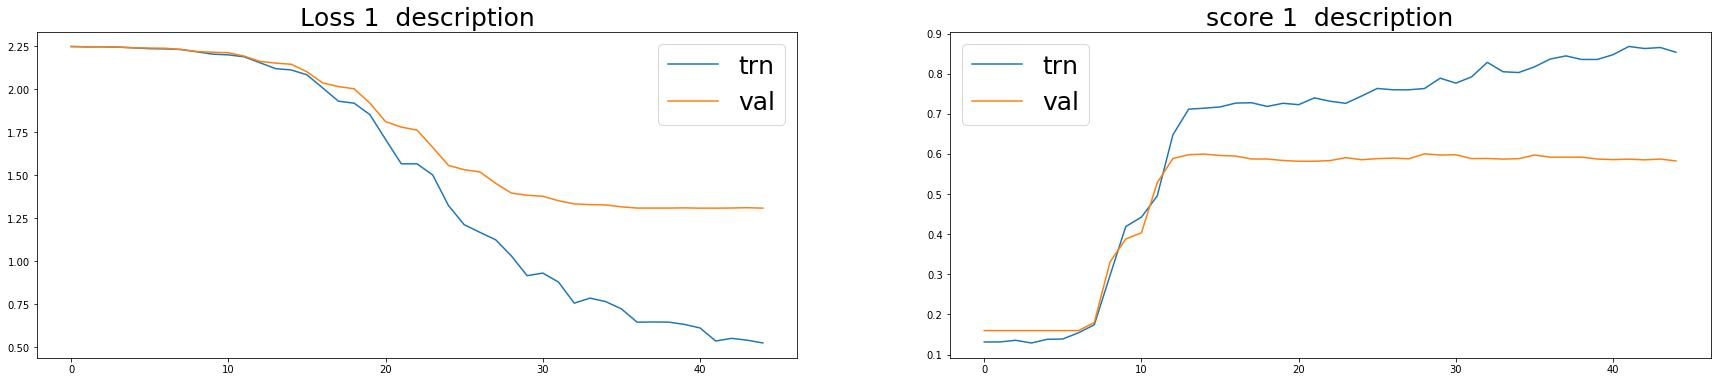

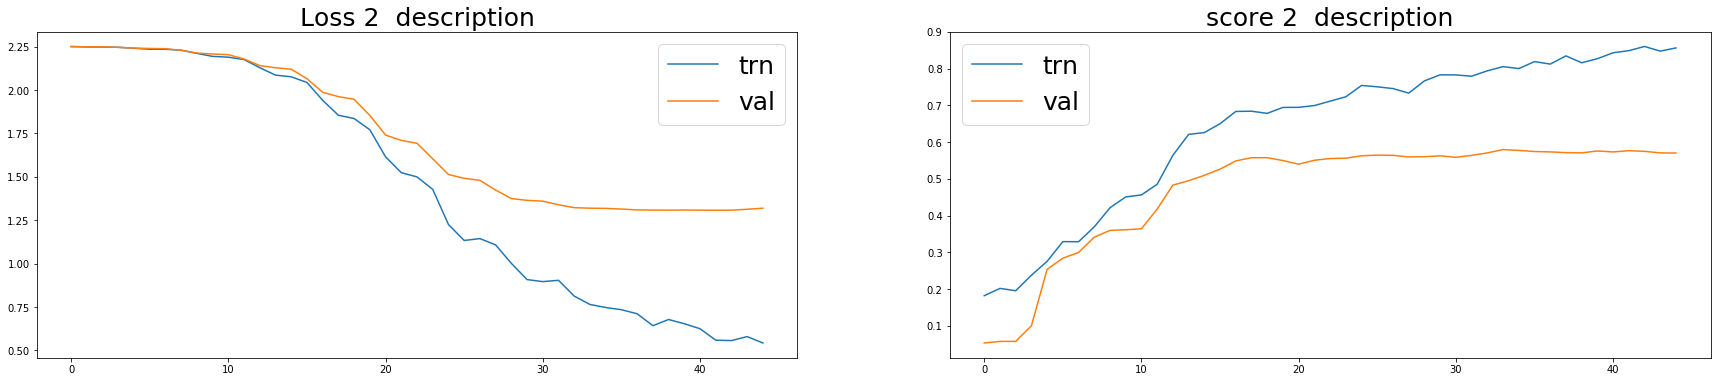

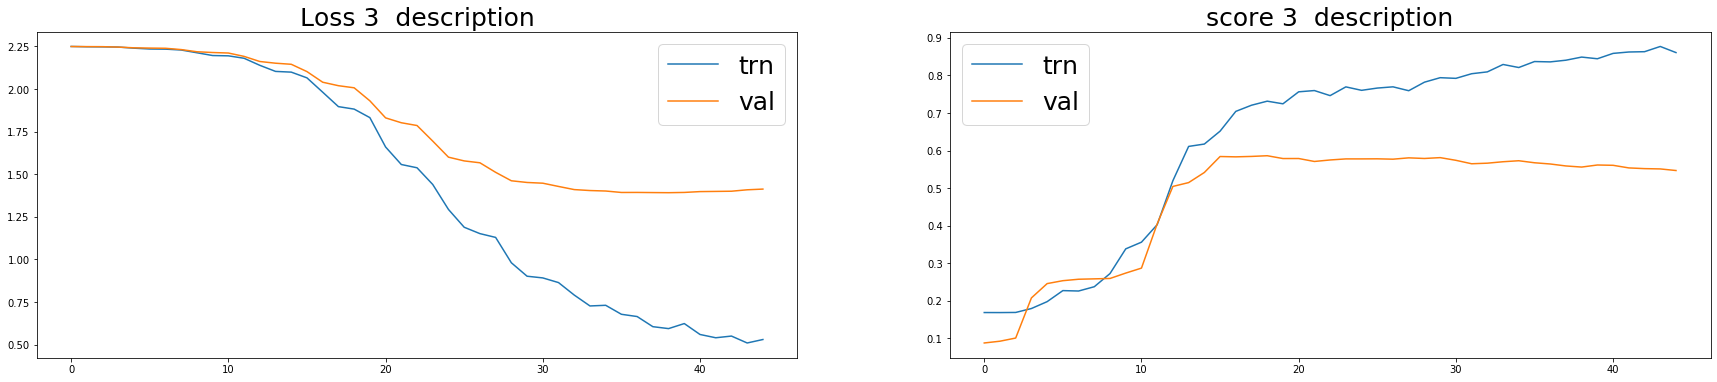

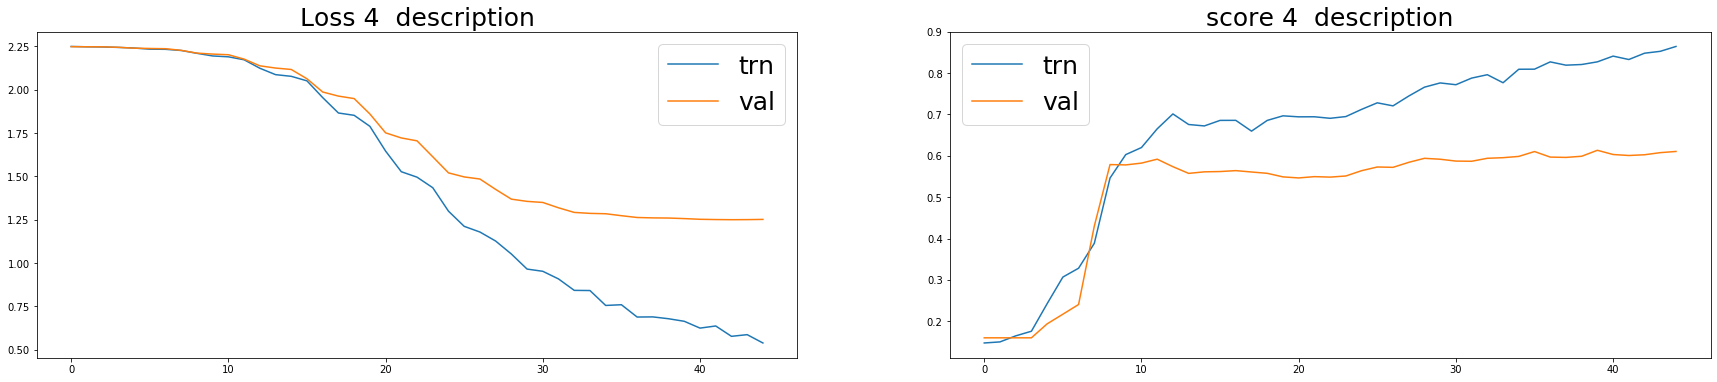

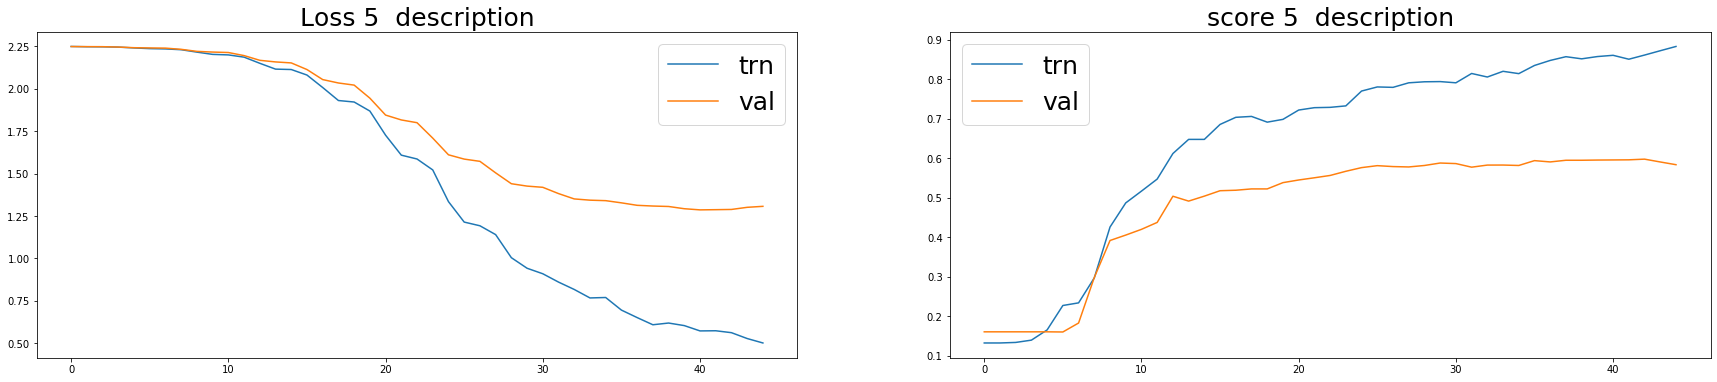

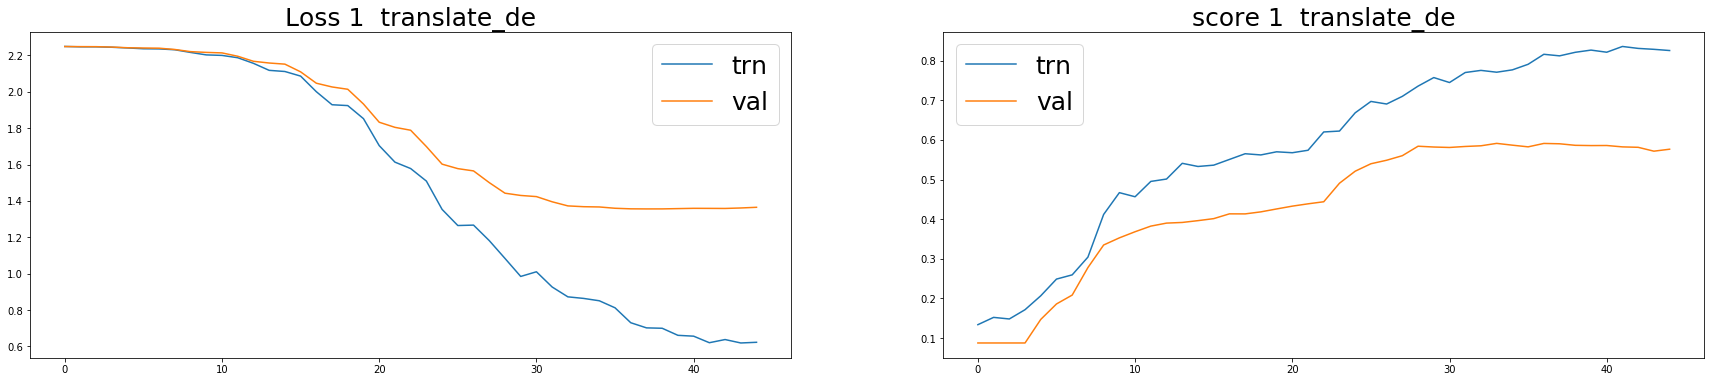

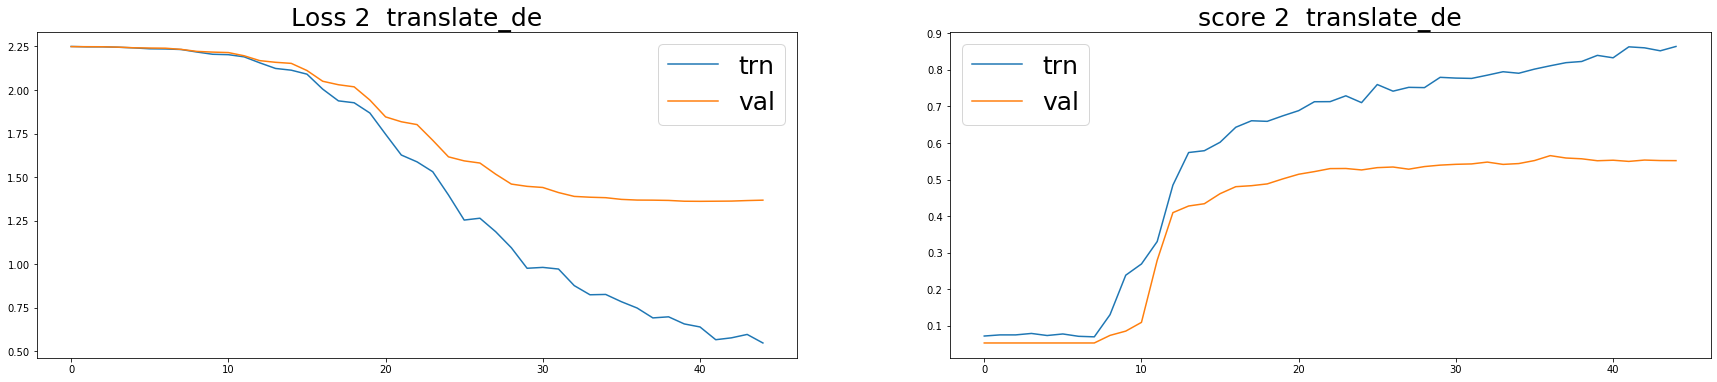

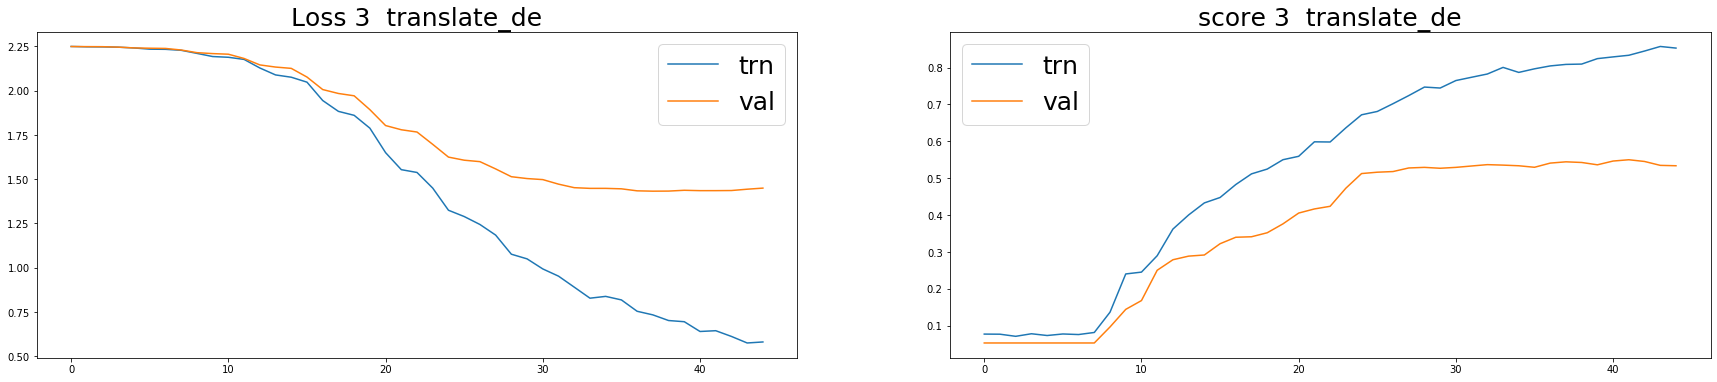

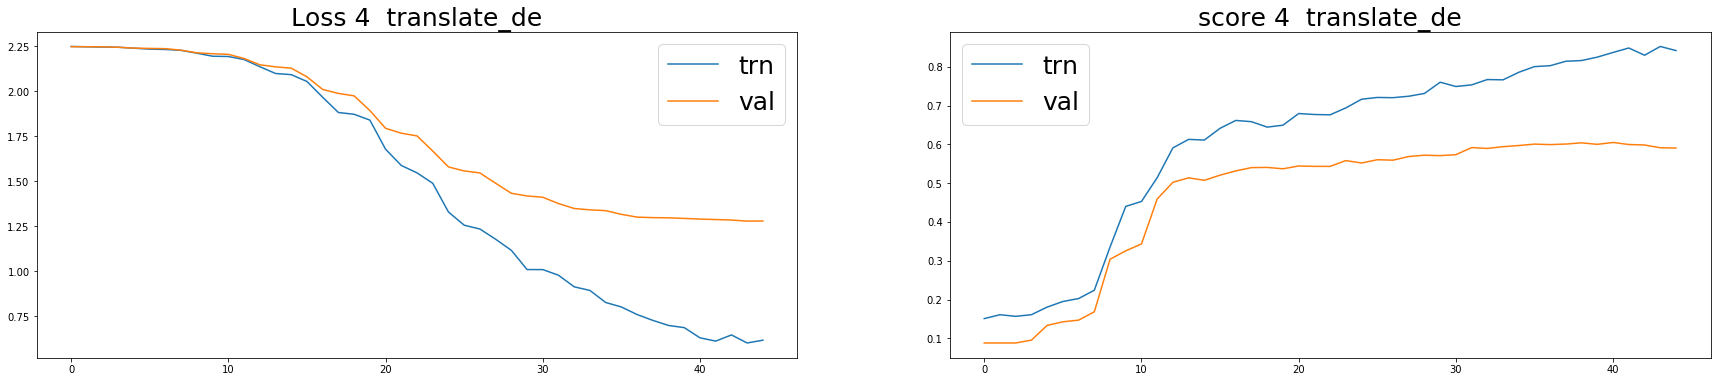

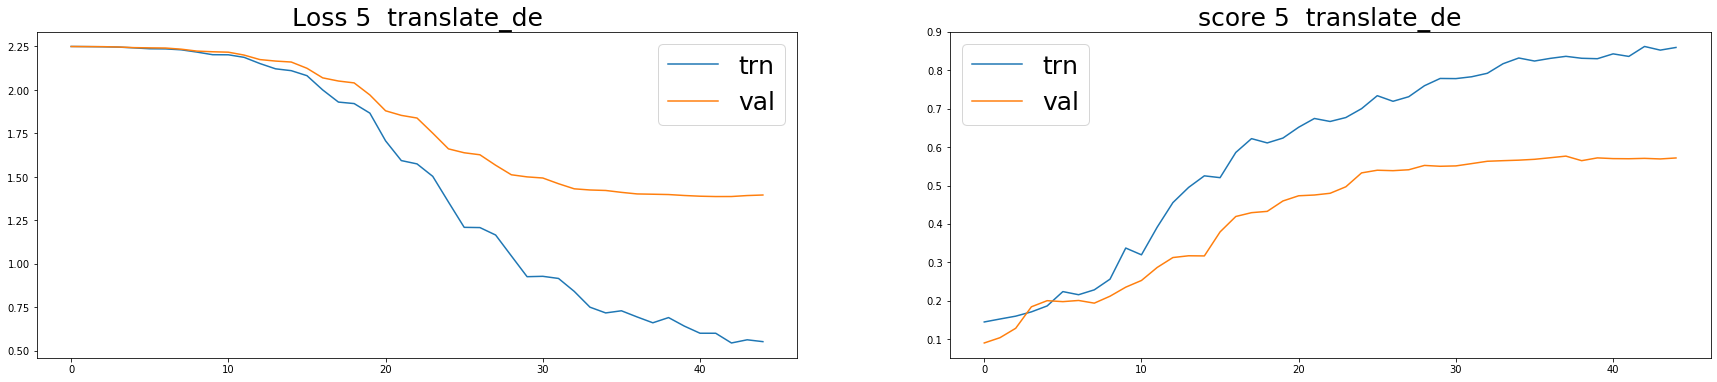

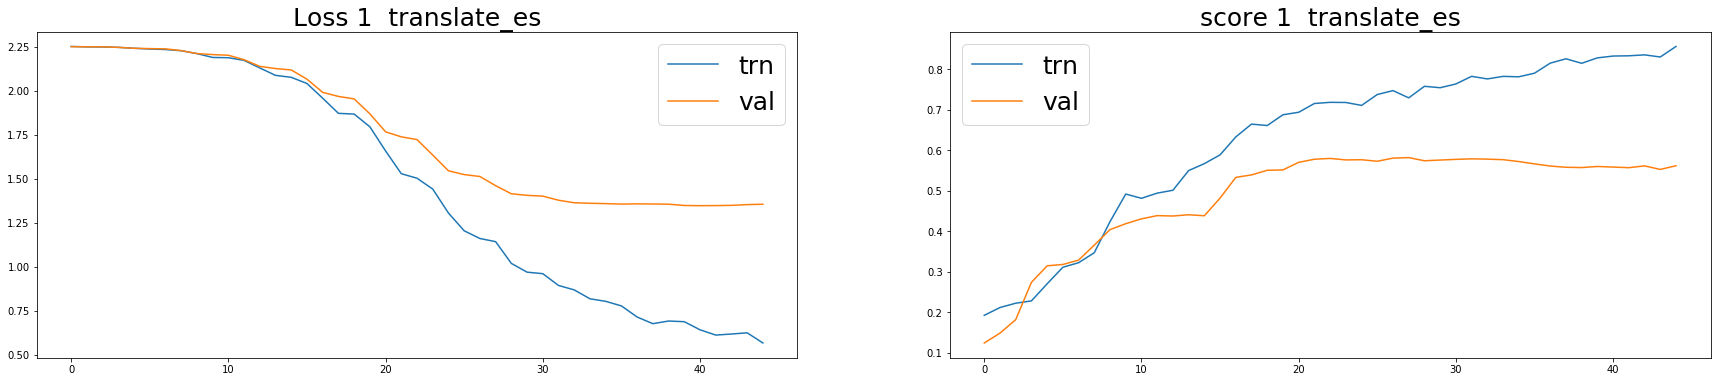

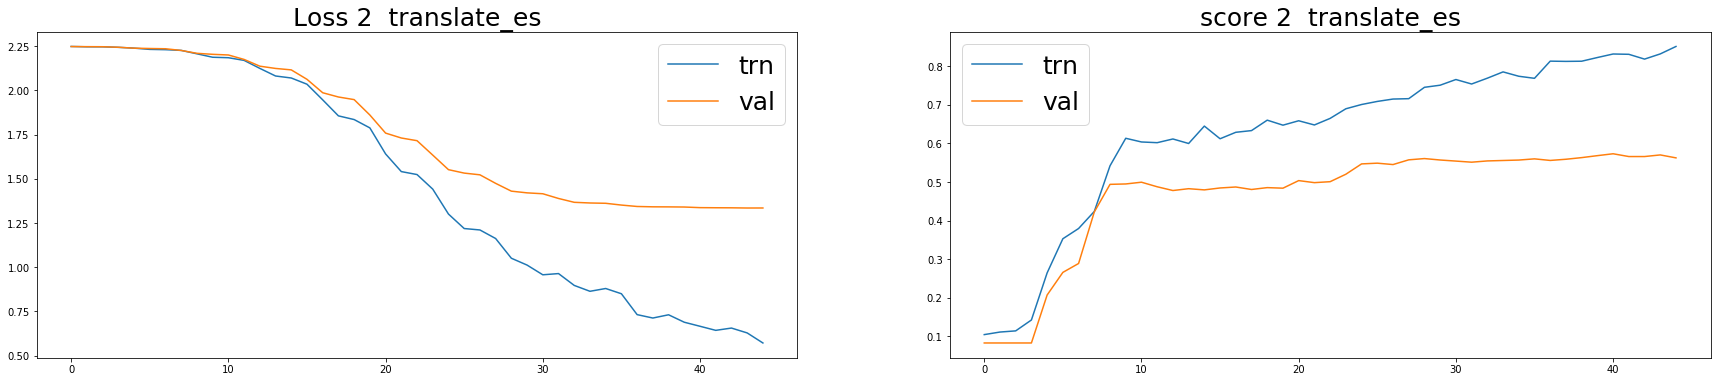

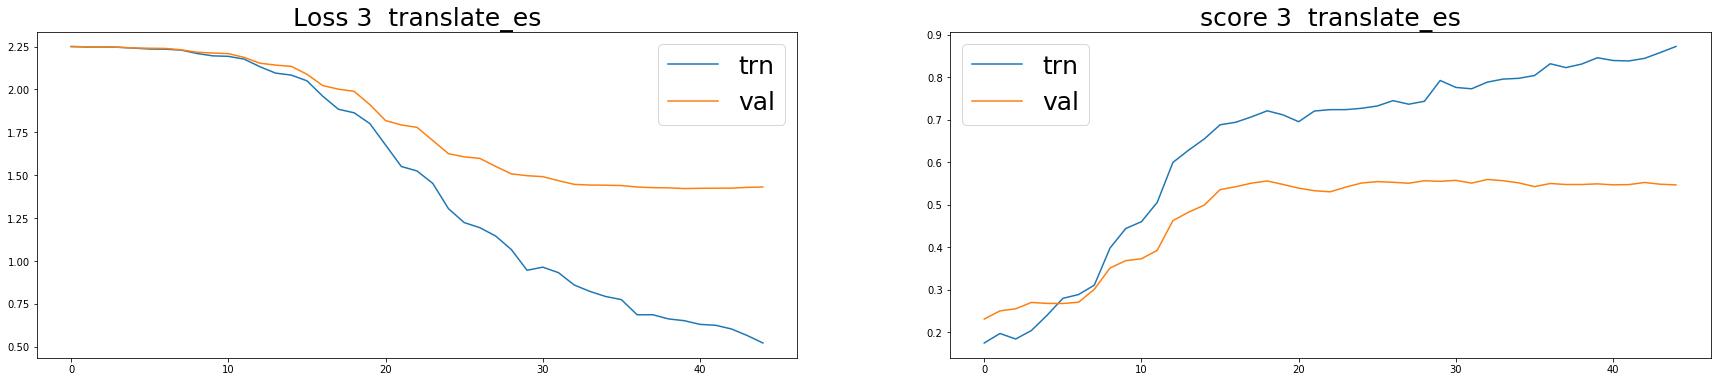

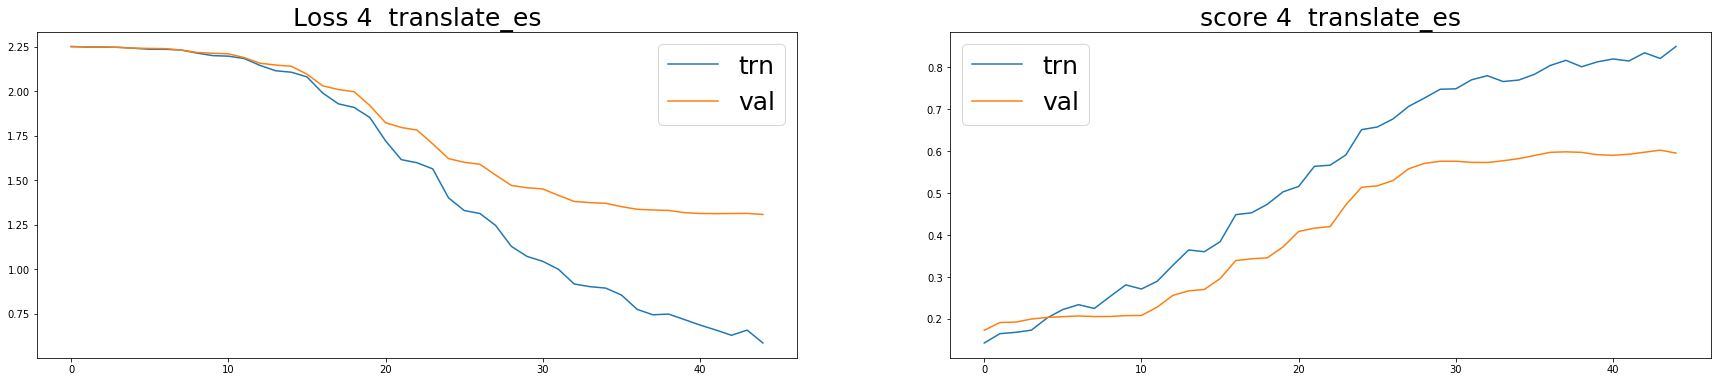

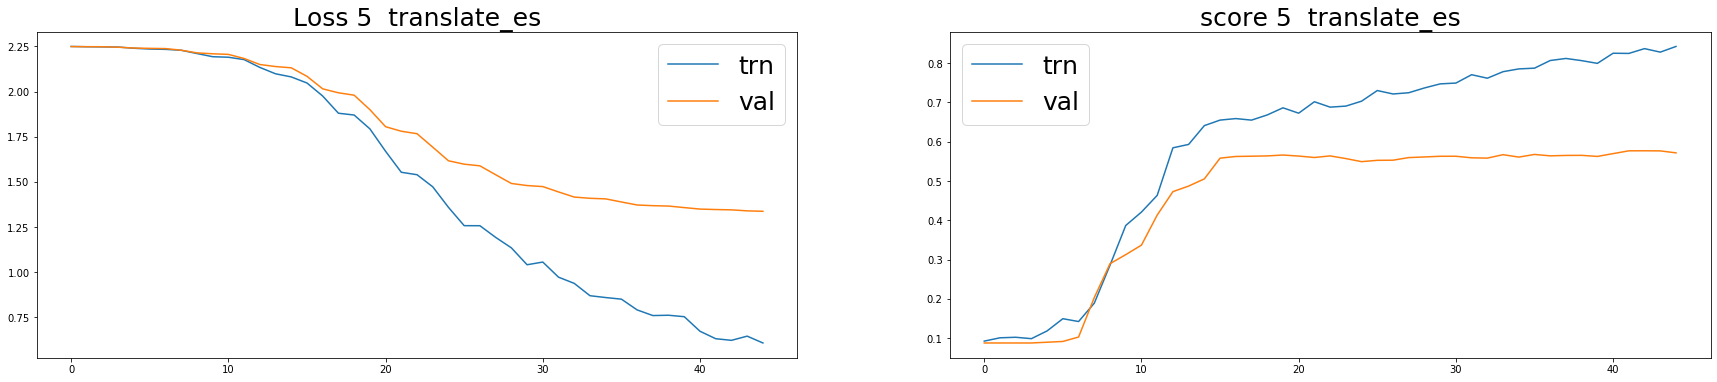

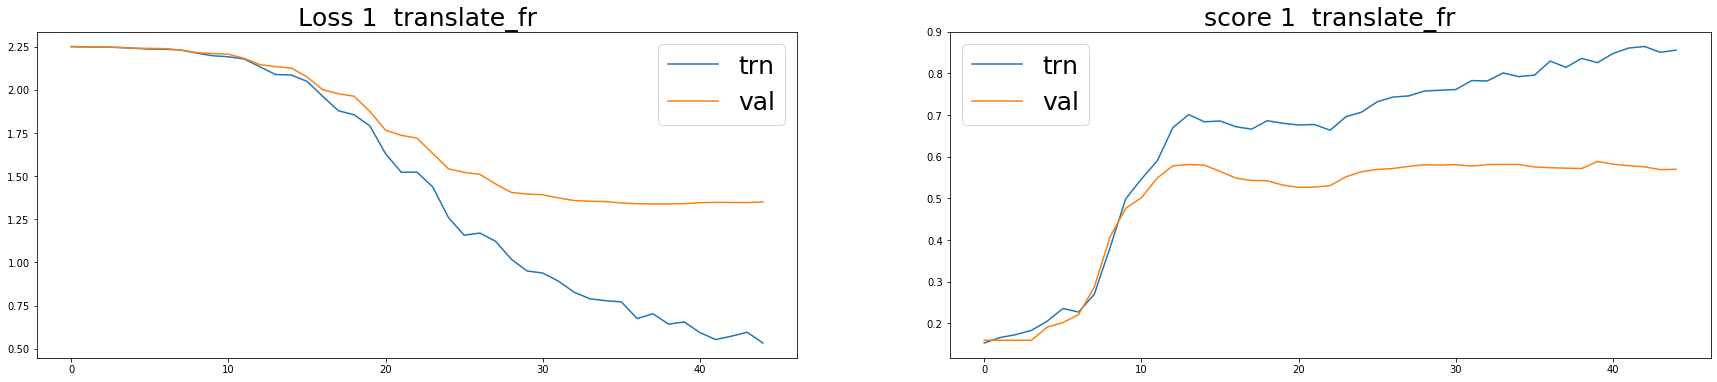

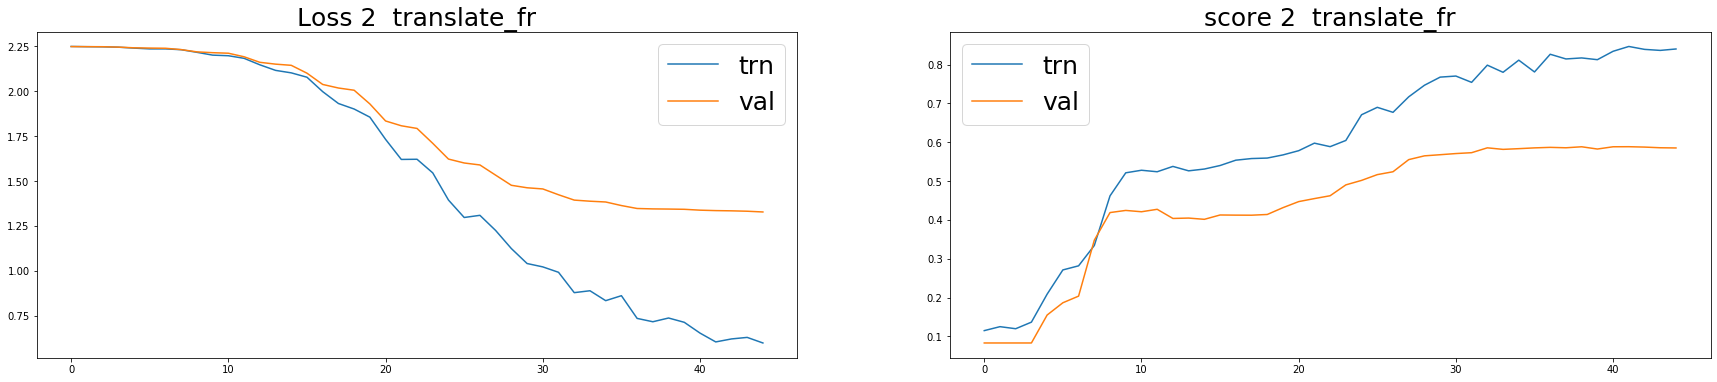

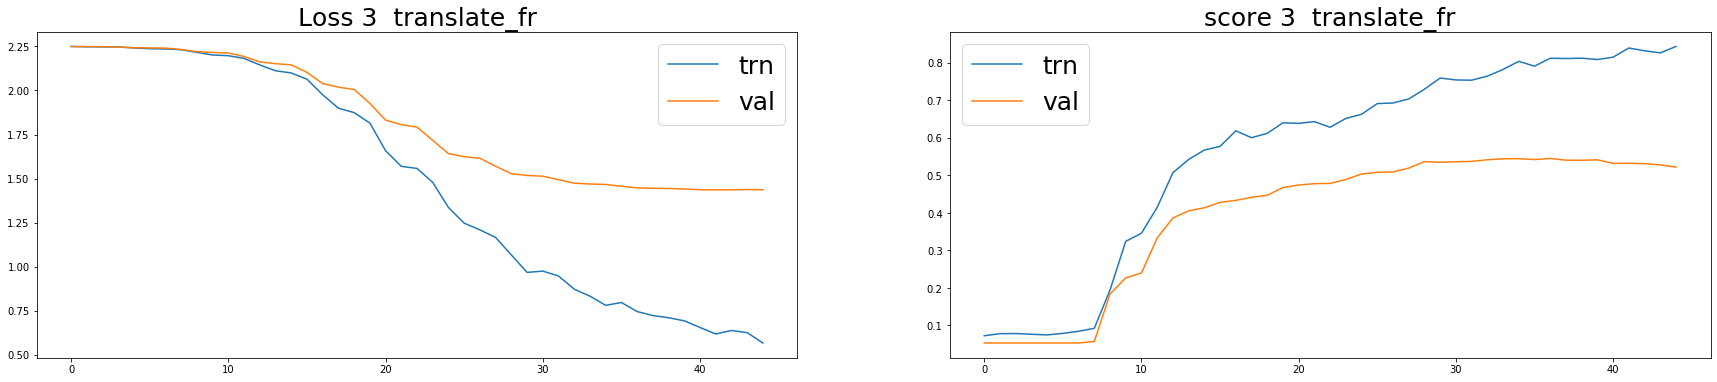

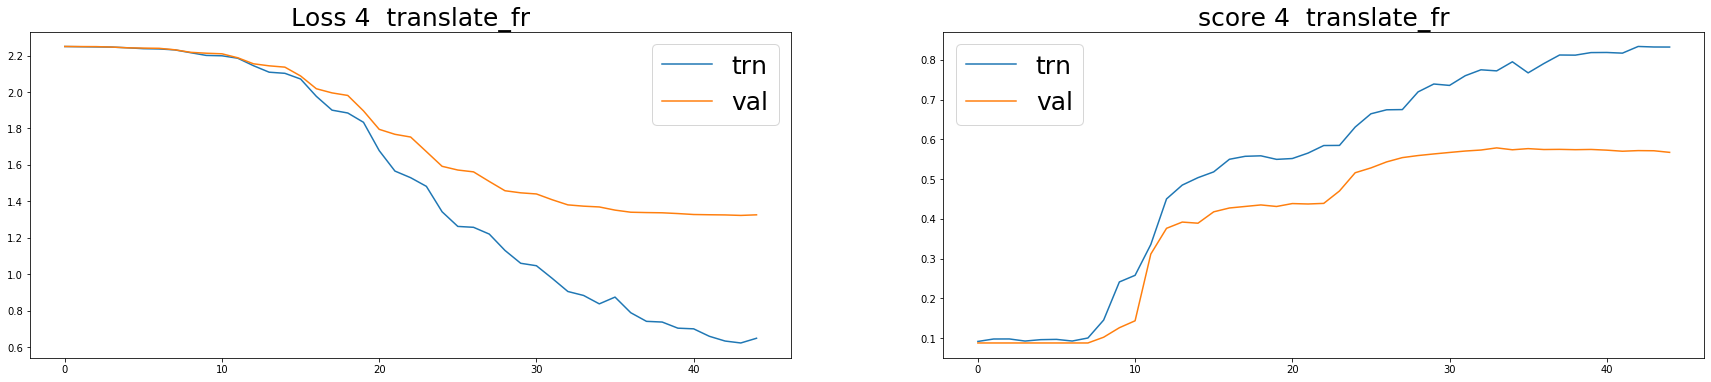

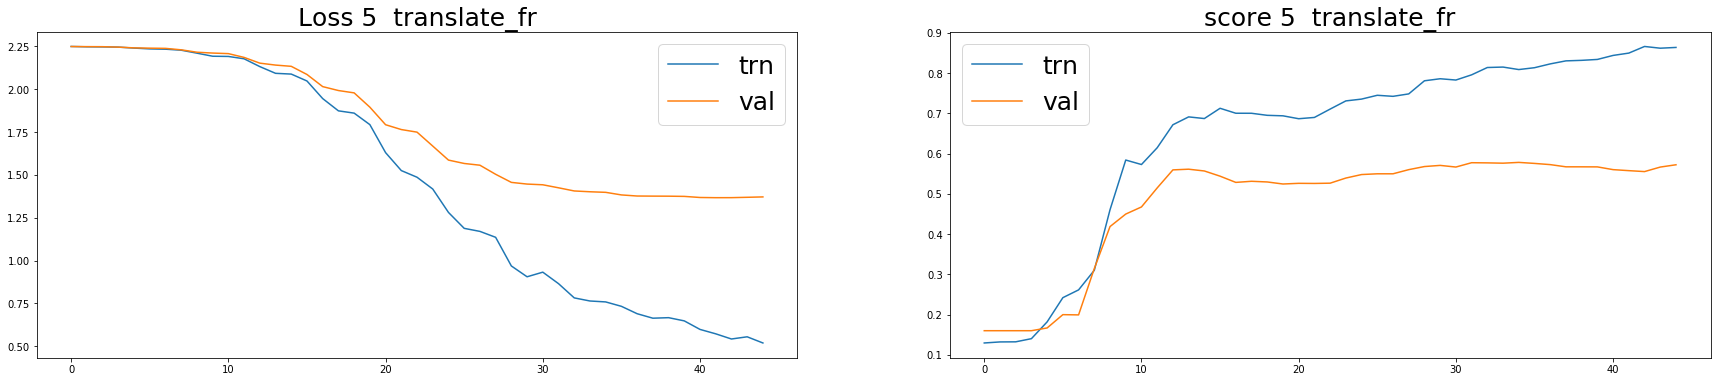

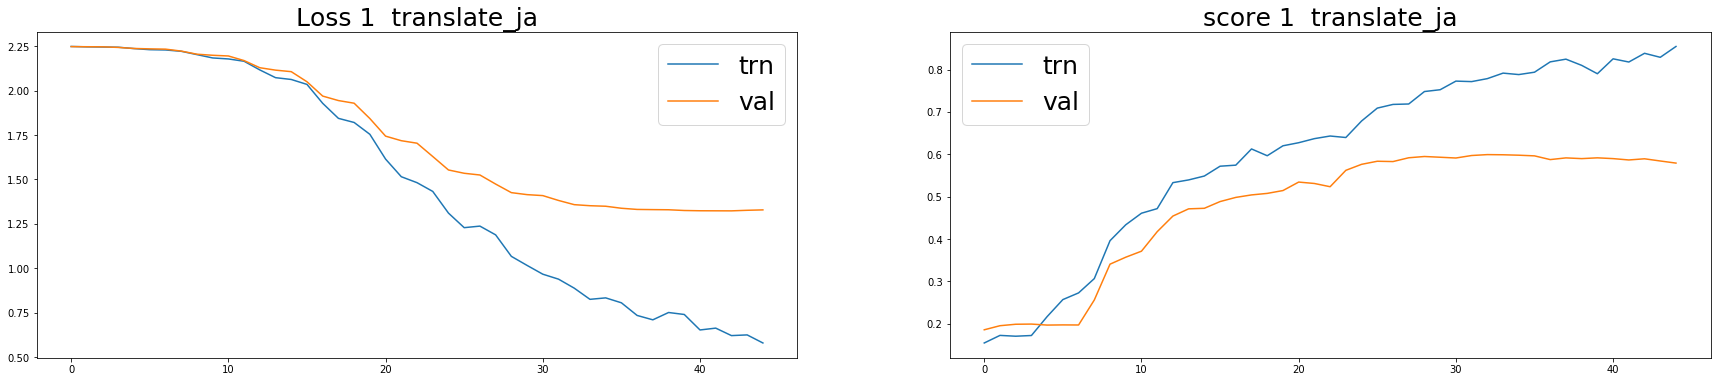

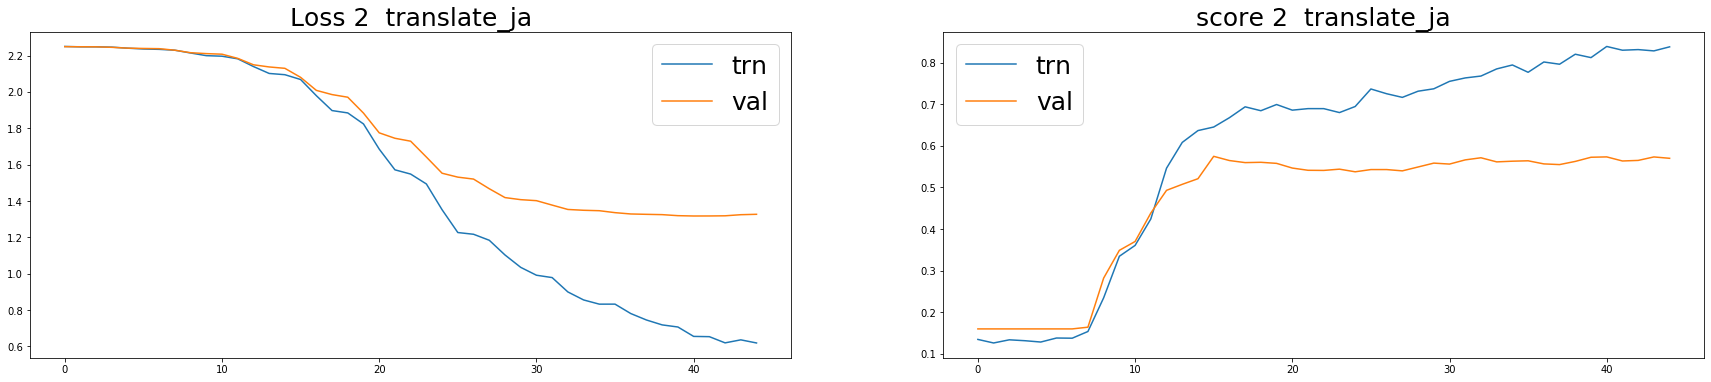

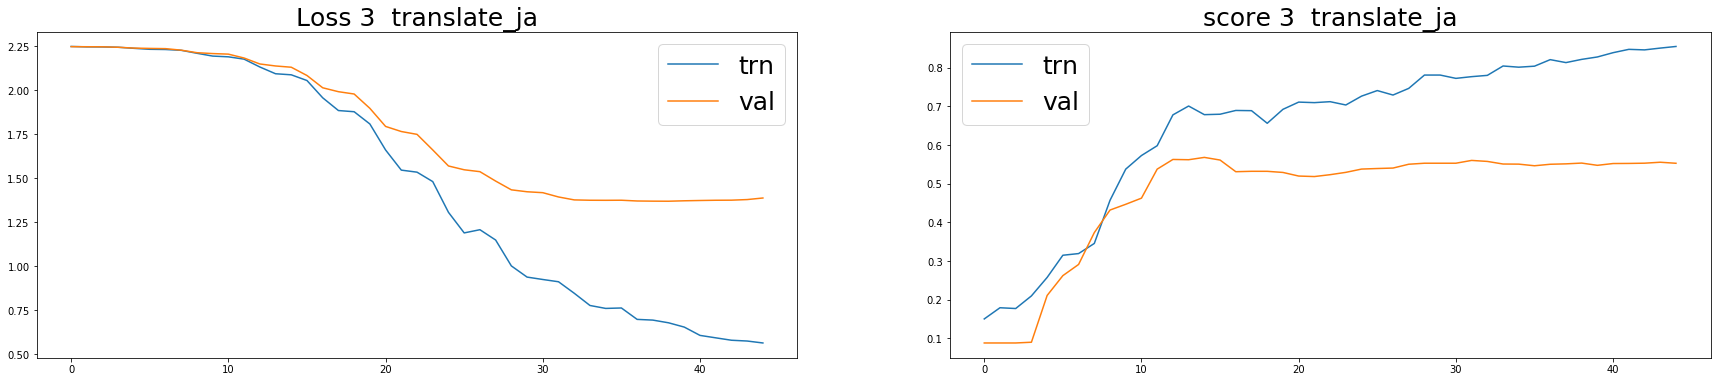

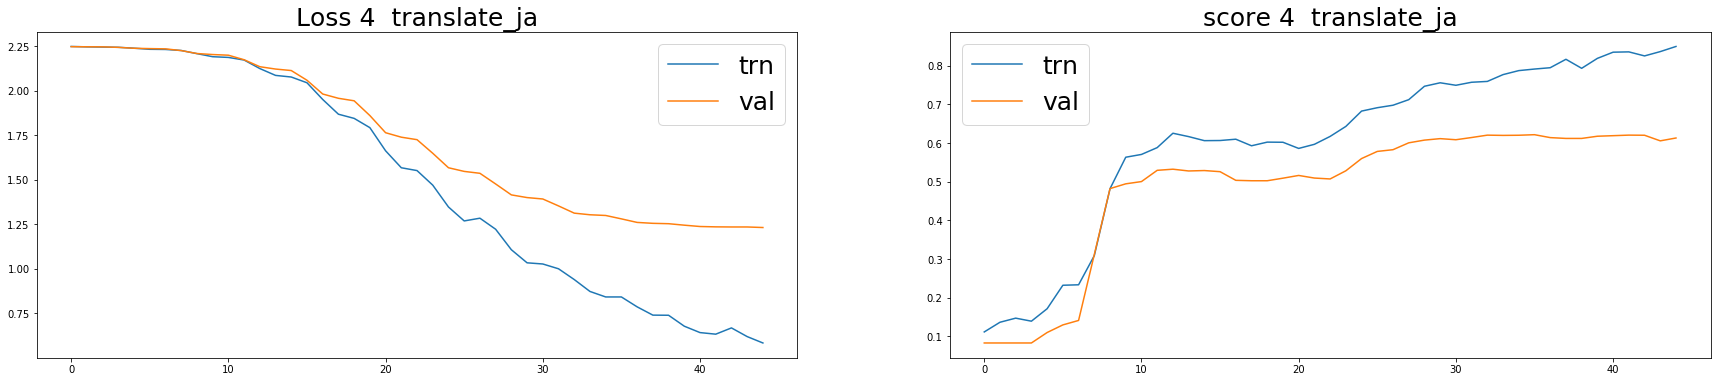

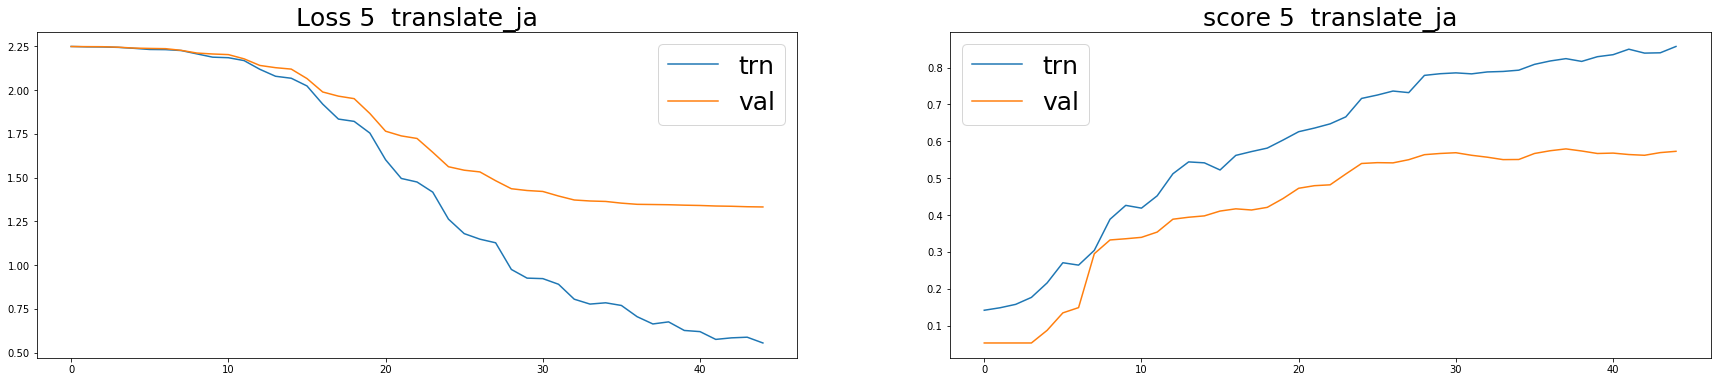

In [51]:
for key in result_dic.keys():
    result_df = result_dic[key]
    for k in range(5):
        plt.figure(figsize=(30,6))
        plt.subplot(1,2,1)
        plt.plot(result_df[f'train_trn_loss_k{k+1}'], label='trn')
        plt.plot(result_df[f'train_val_loss_k{k+1}'], label='val')
        plt.title(f'Loss {k+1}  {key}', fontsize=25)
        plt.legend(fontsize=25)

        plt.subplot(1,2,2)
        plt.plot(result_df[f'train_trn_score_k{k+1}'], label='trn')
        plt.plot(result_df[f'train_val_score_k{k+1}'], label='val')
        plt.title(f'score {k+1}  {key}', fontsize=25)
        plt.legend(fontsize=25)

        plt.show()

In [28]:
mlp_pred_cols = [f'p_{(mm%4)+1}_{e}' for e in range(45) for mm in range(4)]

off_df2 = pd.concat([
    off_df[mlp_pred_cols].rename(columns={col:f'{col}_{lang}' for col in mlp_pred_cols})
 for lang, off_df in off_df_dic.items()
], axis=1)

test_df2 =  pd.concat([
    t_df[mlp_pred_cols].rename(columns={col:f'{col}_{lang}' for col in mlp_pred_cols})
 for lang, t_df in test_df_dic.items()
], axis=1)

mlp_feature2 = [f'{col}_{lang}' for col in mlp_pred_cols for lang in test_df_dic.keys()]
test_df2 = pd.concat([test_df_dic['description']['text_id'], test_df2], axis=1)
off_df2 = pd.concat([off_df_dic['description'][['text_id', 'jobflag']], off_df2], axis=1)

In [58]:
train_predict = Train_Predict(off_df2, test_df2, mlp_feature2, hidden_layers=[300, 100], lr=0.0001, weight_decay=0.000001)

off_df3, test_df_mlp3, trn_cv_loss2, val_cv_loss2, trn_score2, val_score2 = train_predict.make_off_df(
    epoch_num=45, k=k_1
)

In [59]:
data2 = pd.DataFrame()  
for i in range(len(trn_cv_loss2)):
    data2[f'train_trn_loss_k{i+1}'] = trn_cv_loss2[i]
    data2[f'train_val_loss_k{i+1}'] = val_cv_loss2[i]
    data2[f'train_trn_score_k{i+1}'] = trn_score2[i]
    data2[f'train_val_score_k{i+1}'] = val_score2[i]

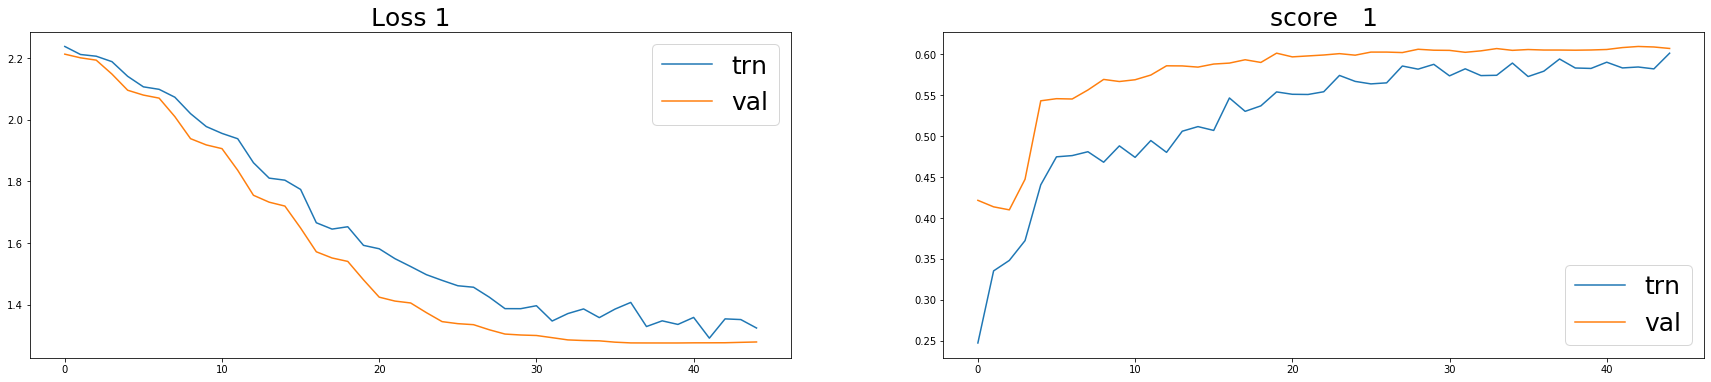

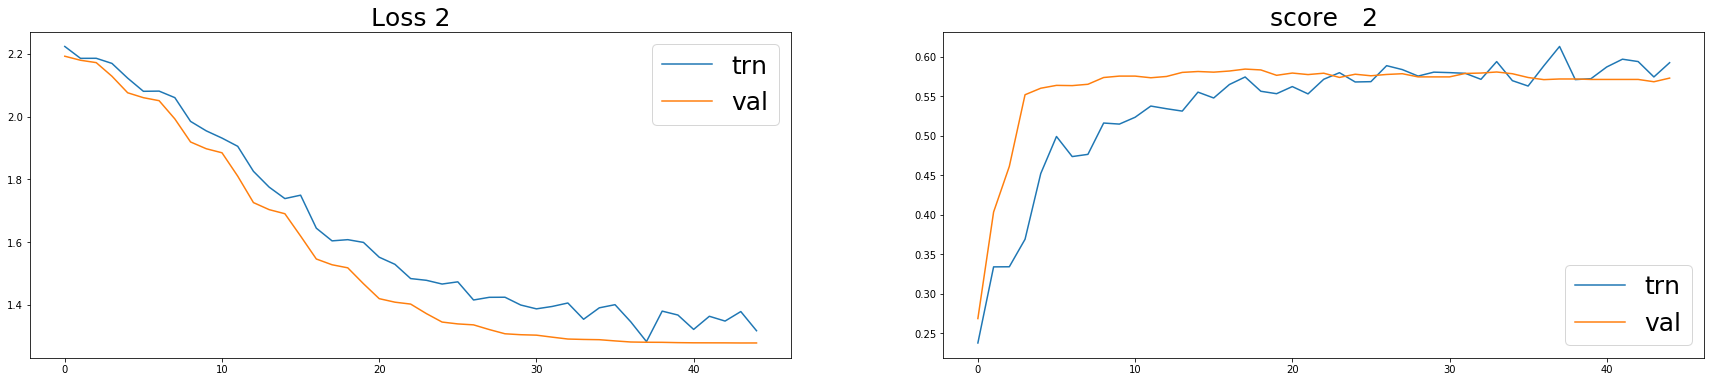

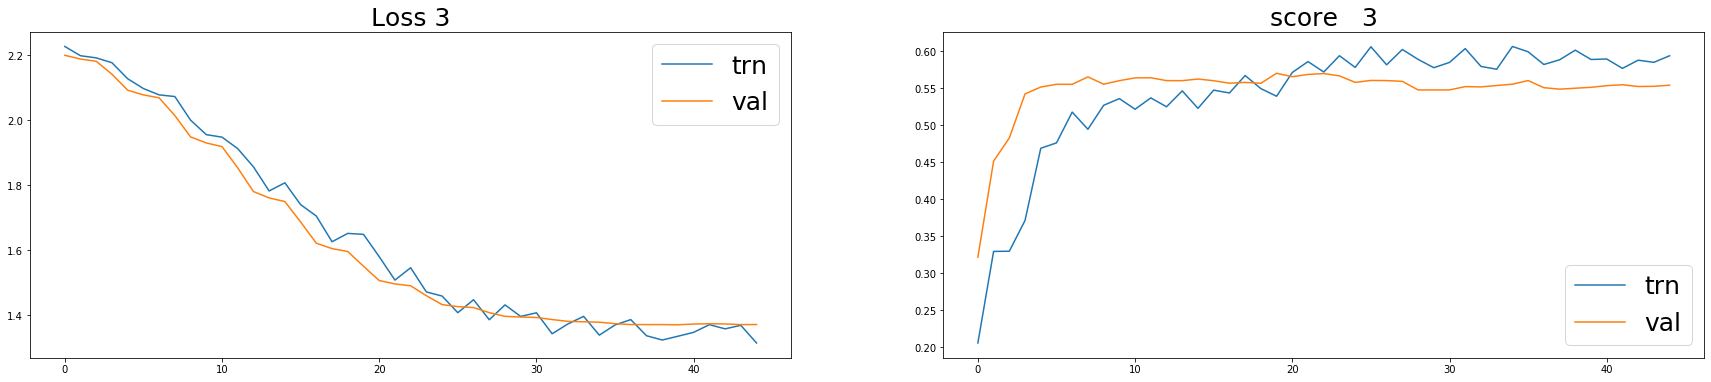

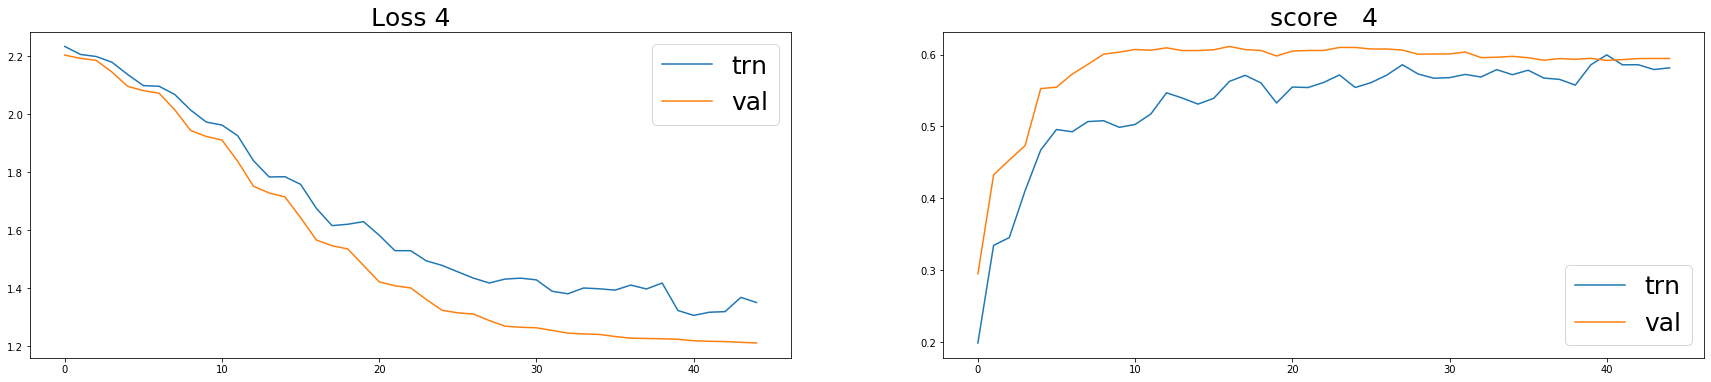

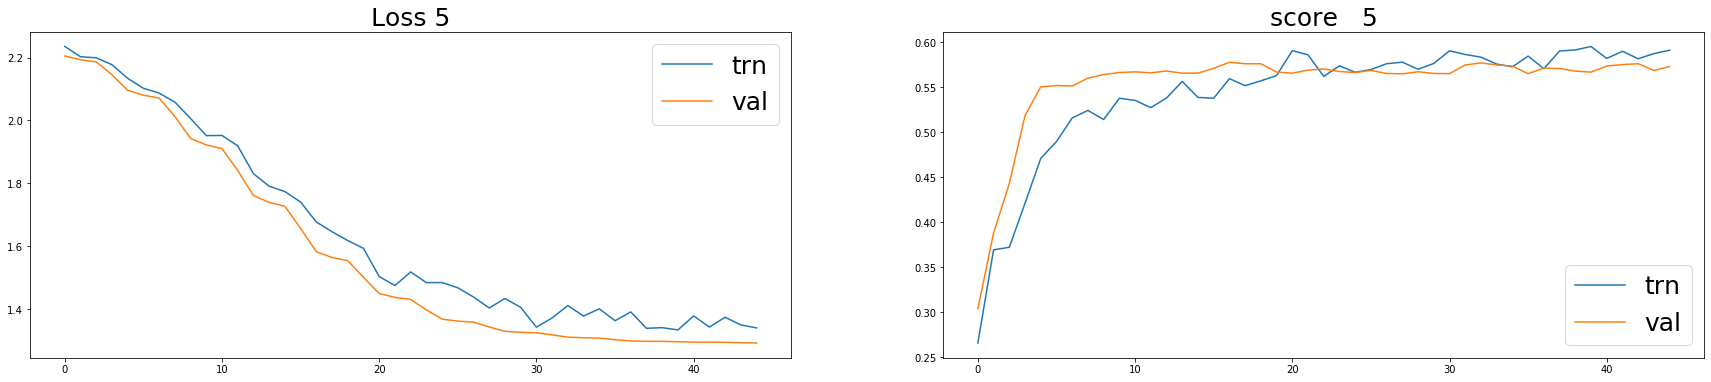

In [60]:
for k in range(5):
    plt.figure(figsize=(30,6))
    plt.subplot(1,2,1)
    plt.plot(data2[f'train_trn_loss_k{k+1}'], label='trn')
    plt.plot(data2[f'train_val_loss_k{k+1}'], label='val')
    plt.title(f'Loss {k+1}', fontsize=25)
    plt.legend(fontsize=25)

    plt.subplot(1,2,2)
    plt.plot(data2[f'train_trn_score_k{k+1}'], label='trn')
    plt.plot(data2[f'train_val_score_k{k+1}'], label='val')
    plt.title(f'score   {k+1}', fontsize=25)
    plt.legend(fontsize=25)
plt.show()

In [80]:
preds=np.zeros((len(test_df_mlp3), 4))
for e in range(40,45):
    p=test_df_mlp3[[f'p_{mm+1}_{e}_description' for mm in range(4)]].values
    preds+=p
preds = np.argmax(preds, axis=1)

In [81]:
np.unique(preds, return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([418, 204, 709, 412], dtype=int64))

In [79]:
data = pd.read_csv('/Users/abcdm/Downloads/sub_18.csv', header=None)
data[1].value_counts()

3    571
4    529
1    398
2    245
Name: 1, dtype: int64